In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Phase 2 strategy logic
# -------------------------------
from phase_2.scripts.strategies.trend.trend_strategy_v1 import (
    run_trend_strategy_v1,
)

from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import (
    run_meanrev_strategy_v1,
)

from phase_2.scripts.strategies.meta.meta_allocator_v1 import (
    build_regime_features,
)

# -------------------------------
# Phase 3 hysteresis allocator
# -------------------------------
from phase_3.strategies.meta.meta_allocator_hysteresis_v1 import (
    build_meta_raw_returns_hysteresis_v1,
    DEFAULT_HYST_PARAMS,
)


In [2]:
spy = pd.read_parquet("../../phase_2/data/processed/spy_daily.parquet")

spy["date"] = pd.to_datetime(spy["date"])
spy = spy.sort_values("date").reset_index(drop=True)
spy["year"] = spy["date"].dt.year

spy.head()


,date,open,high,low,close,adj_close,volume,year
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,85.027946,118944600,2010
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,85.253067,111579900,2010
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,85.313049,116074400,2010
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,85.673180,131091100,2010
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,85.958290,126402800,2010


In [3]:
trend_out = run_trend_strategy_v1(
    spy,
    train_df=spy,   # allowed for smoke test
)

meanrev_out = run_meanrev_strategy_v1(
    spy,
)


In [4]:
regime = build_regime_features(spy)

regime.head()


,date,open,high,low,close,adj_close,volume,year,ret_1d,mom_20,mom_60,vol_20,drawdown_60
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,85.027946,118944600,2010,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,85.253067,111579900,2010,0.002648,NaN,NaN,NaN,NaN
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,85.313049,116074400,2010,0.000704,NaN,NaN,NaN,NaN
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,85.673180,131091100,2010,0.004221,NaN,NaN,NaN,NaN
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,85.958290,126402800,2010,0.003328,NaN,NaN,NaN,NaN


In [5]:
hyst = build_meta_raw_returns_hysteresis_v1(
    trend_out=trend_out,
    meanrev_out=meanrev_out,
    regime_df=regime,
    p=DEFAULT_HYST_PARAMS,
)

hyst.head(10)


,date,state,meta_raw_ret
0,2010-01-04,CASH,0.0
1,2010-01-05,CASH,0.0
2,2010-01-06,CASH,0.0
3,2010-01-07,CASH,0.0
4,2010-01-08,CASH,0.0
5,2010-01-11,CASH,0.0
6,2010-01-12,CASH,0.0
7,2010-01-13,CASH,0.0
8,2010-01-14,CASH,0.0
9,2010-01-15,CASH,0.0


In [6]:
hyst["state"].value_counts(normalize=True)


state
TREND      0.697391
MEANREV    0.175901
CASH       0.126708
Name: proportion, dtype: float64

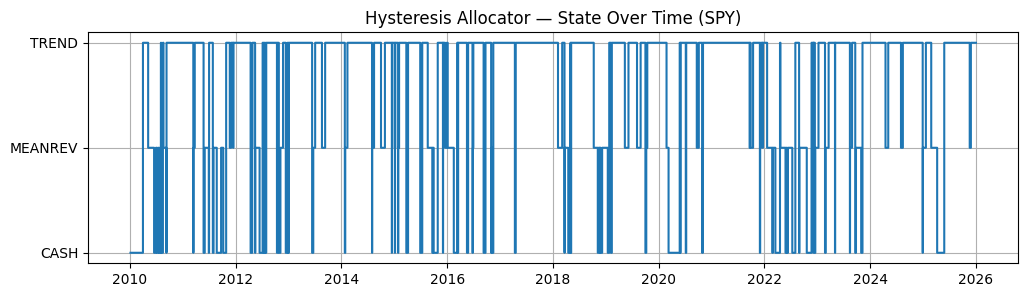

In [7]:
state_map = {
    "CASH": 0,
    "MEANREV": 1,
    "TREND": 2,
}

plt.figure(figsize=(12, 3))
plt.plot(
    hyst["date"],
    hyst["state"].map(state_map),
    drawstyle="steps-post",
)
plt.yticks([0, 1, 2], ["CASH", "MEANREV", "TREND"])
plt.title("Hysteresis Allocator — State Over Time (SPY)")
plt.grid(True)
plt.show()


In [8]:
from phase_2.scripts.strategies.meta.meta_allocator_v1 import (
    build_meta_raw_returns_param_v1,
)

HARD_PARAMS_TIGHT = {
    "trend_mom60_min": 0.0,
    "trend_mom20_min": -0.005,
    "meanrev_mom20_max": -0.025,
    "meanrev_dd60_max": -0.03,
    "meanrev_vol20_max": 0.40,
}

hard = build_meta_raw_returns_param_v1(
    trend_out,
    meanrev_out,
    regime,
    HARD_PARAMS_TIGHT,
)


In [9]:
def state_churn(states: pd.Series) -> int:
    return (states != states.shift()).sum()

print("Hard allocator churn:", state_churn(hard["state"]))
print("Hysteresis allocator churn:", state_churn(hyst["state"]))


Hard allocator churn: 472
Hysteresis allocator churn: 196


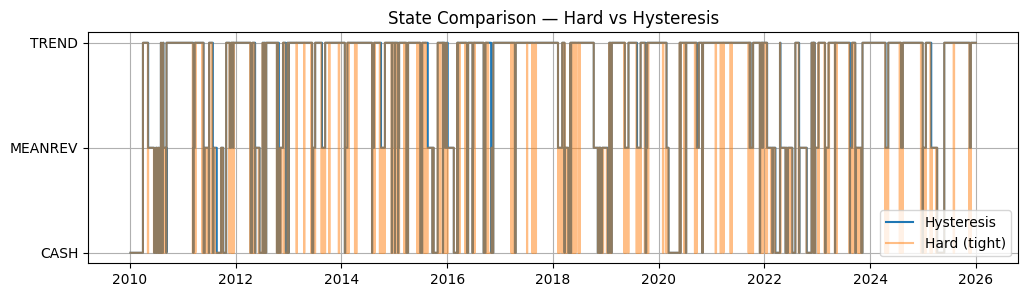

In [10]:
plt.figure(figsize=(12,3))
plt.plot(
    hyst["date"],
    hyst["state"].map(state_map),
    label="Hysteresis",
    drawstyle="steps-post",
)
plt.plot(
    hard["date"],
    hard["state"].map(state_map),
    label="Hard (tight)",
    alpha=0.5,
    drawstyle="steps-post",
)
plt.yticks([0,1,2], ["CASH", "MEANREV", "TREND"])
plt.legend()
plt.title("State Comparison — Hard vs Hysteresis")
plt.grid(True)
plt.show()
